In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip

The dataset link is given here :  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip

In [ ]:
!jar xf 2011_10_03_drive_0047_sync.zip
!jar xf 2011_10_03_calib.zip

In [ ]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

In [ ]:
!wget https://github.com/itberrios/CV_tracking/raw/main/kitti_tracker/kitti_utils.py
from kitti_utils import *

In [ ]:
with open('2011_10_03/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices (rectified left camera --> left camera (u,v,z))
P_rect2_cam2 = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))


# get rectified rotation matrices (left camera --> rectified left camera)
R_ref0_rect2 = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))

# add (0,0,0) translation and convert to homogeneous coordinates
R_ref0_rect2 = np.insert(R_ref0_rect2, 3, values=[0,0,0], axis=0)
R_ref0_rect2 = np.insert(R_ref0_rect2, 3, values=[0,0,0,1], axis=1)


# get rigid transformation from Camera 0 (ref) to Camera 2
R_2 = np.array([float(x) for x in calib[21].strip().split(' ')[1:]]).reshape((3,3))
t_2 = np.array([float(x) for x in calib[22].strip().split(' ')[1:]]).reshape((3,1))

# get cam0 to cam2 rigid body transformation in homogeneous coordinates
T_ref0_ref2 = np.insert(np.hstack((R_2, t_2)), 3, values=[0,0,0,1], axis=0)

In [ ]:
T_velo_ref0 = get_rigid_transformation(r'2011_10_03/calib_velo_to_cam.txt')
T_imu_velo = get_rigid_transformation(r'2011_10_03/calib_imu_to_velo.txt')

In [ ]:
# transform from velo (LiDAR) to left color camera (shape 3x4)
T_velo_cam2 = P_rect2_cam2 @ R_ref0_rect2 @ T_ref0_ref2 @ T_velo_ref0

# homogeneous transform from left color camera to velo (LiDAR) (shape: 4x4)
T_cam2_velo = np.linalg.inv(np.insert(T_velo_cam2, 3, values=[0,0,0,1], axis=0))

In [ ]:
# transform from IMU to left color camera (shape 3x4)
T_imu_cam2 = T_velo_cam2 @ T_imu_velo

# homogeneous transform from left color camera to IMU (shape: 4x4)
T_cam2_imu = np.linalg.inv(np.insert(T_imu_cam2, 3, values=[0,0,0,1], axis=0))

In [ ]:
!git clone https://github.com/ultralytics/yolov5

In [ ]:
!pip install -r yolov5/requirements.txt

In [ ]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

In [ ]:
model.conf = 0.25  # confidence threshold (0-1), default: 0.25
model.iou = 0.25  # NMS IoU threshold (0-1), default: 0.45

In [ ]:
def get_uvz_centers(image, velo_uvz, bboxes, draw=True):

    # unpack LiDAR camera coordinates
    u, v, z = velo_uvz

    # get new output
    bboxes_out = np.zeros((bboxes.shape[0], bboxes.shape[1] + 3))
    bboxes_out[:, :bboxes.shape[1]] = bboxes

    # iterate through all detected bounding boxes
    for i, bbox in enumerate(bboxes):
        pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
        pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()

        # get center location of the object on the image
        obj_x_center = (pt1[1] + pt2[1]) / 2
        obj_y_center = (pt1[0] + pt2[0]) / 2

        # now get the closest LiDAR points to the center
        center_delta = np.abs(np.array((v, u))
                              - np.array([[obj_x_center, obj_y_center]]).T)

        # choose coordinate pair with the smallest L2 norm
        min_loc = np.argmin(np.linalg.norm(center_delta, axis=0))

        # get LiDAR location in image/camera space
        velo_depth = z[min_loc]; # LiDAR depth in camera space
        uvz_location = np.array([u[min_loc], v[min_loc], velo_depth])

        # add velo projections (u, v, z) to bboxes_out
        bboxes_out[i, -3:] = uvz_location

        # draw depth on image at center of each bounding box
        # This is depth as perceived by the camera
        if draw:
            object_center = (np.round(obj_y_center).astype(int),
                             np.round(obj_x_center).astype(int))
            cv2.putText(image,
                        '{0:.2f} m'.format(velo_depth),
                        object_center, # top left
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, # font scale
                        (255, 0, 0), 2, cv2.LINE_AA)

    return bboxes_out

In [ ]:
def get_detection_coordinates(image, bin_path, draw_boxes=True, draw_depth=True):

    ## 1. compute detections in the left image
    detections = model(image)

    # draw boxes on image
    if draw_boxes:
        detections.show()

    # get bounding box locations (x1,y1), (x2,y2) Prob, class
    bboxes = detections.xyxy[0].cpu() # remove from GPU

    # get LiDAR points and transform them to image/camera space
    velo_uvz = project_velobin2uvz(bin_path,
                                   T_velo_cam2,
                                   image,
                                   remove_plane=True)

    # get uvz centers for detected objects
    bboxes = get_uvz_centers(image,
                             velo_uvz,
                             bboxes,
                             draw=draw_depth)

    return bboxes, velo_uvz

**#Convert IMU to LLA**


Now we need to convert the object IMU
(x, y, z) coordinates to Azimuth, Elevation, and Range. Then we can use pymap3d to convert the object centers to Latitude, Longitude, and Altitude. TThe altitude the KITTI dataset does not specify what type of altitude, but the OXTS documentation states that it can measure either geoidal (MSL) or ellipsoidal (HAE), for details see this. We will go ahead and assume that altitude doesn't matter

In [ ]:
!pip install pymap3d

In [ ]:
import pymap3d as pm


def imu2geodetic(x, y, z, lat0, lon0, alt0, heading0):

    # convert to RAE
    rng = np.sqrt(x**2 + y**2 + z**2)
    az = np.degrees(np.arctan2(y, x)) + np.degrees(heading0)
    el = np.degrees(np.arctan2(np.sqrt(x**2 + y**2), z)) + 90

    # convert to geodetic
    lla = pm.aer2geodetic(az, el, rng, lat0, lon0, alt0)

    # convert to numpy array
    lla = np.vstack((lla[0], lla[1], lla[2])).T

    return lla

In [ ]:
DATA_PATH=r'2011_10_03/2011_10_03_drive_0047_sync'
#get RGB camera data
left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/.png')))

#get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))
#get GPS/IMU data
oxts_paths = sorted(glob(os.path.join(DATA_PATH, r'oxts/data**/*.txt')))
print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LIDAR point clouds: {len(bin_paths)}")
print(f"Number of GPS/IMU frames: {len(oxts_paths)}")

WARNING ⚠️ NMS time limit 0.550s exceeded


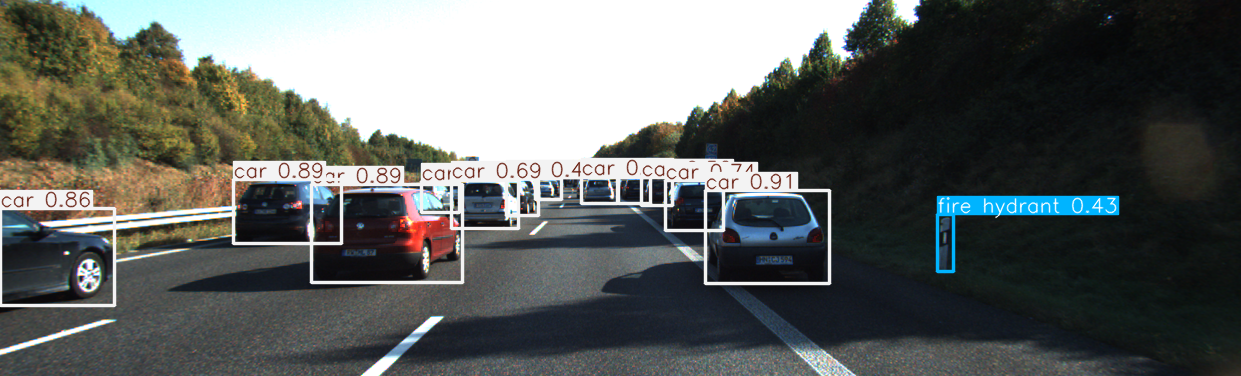

In [ ]:
index = 10

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
bin_path = bin_paths[index]
oxts_frame = get_oxts(oxts_paths[index])

# get detections and object centers in uvz
bboxes, velo_uvz = get_detection_coordinates(left_image, bin_path)

# get transformed coordinates of object centers
uvz = bboxes[:, -3:]

# transform to (u,v,z)
# velo_xyz = transform_uvz(uvz, T_cam2_velo) # we can also get LiDAR coordiantes
imu_xyz = transform_uvz(uvz, T_cam2_imu)

# get Lat/Lon on each detected object
lat0 = oxts_frame[0]
lon0 = oxts_frame[1]
alt0 = oxts_frame[2]
heading0 = oxts_frame[5]

lla = imu2geodetic(imu_xyz[:, 0], imu_xyz[:, 1], imu_xyz[:, 2], lat0, lon0, alt0, heading0)

In [ ]:
velo_image = draw_velo_on_image(velo_uvz, np.zeros_like(left_image))

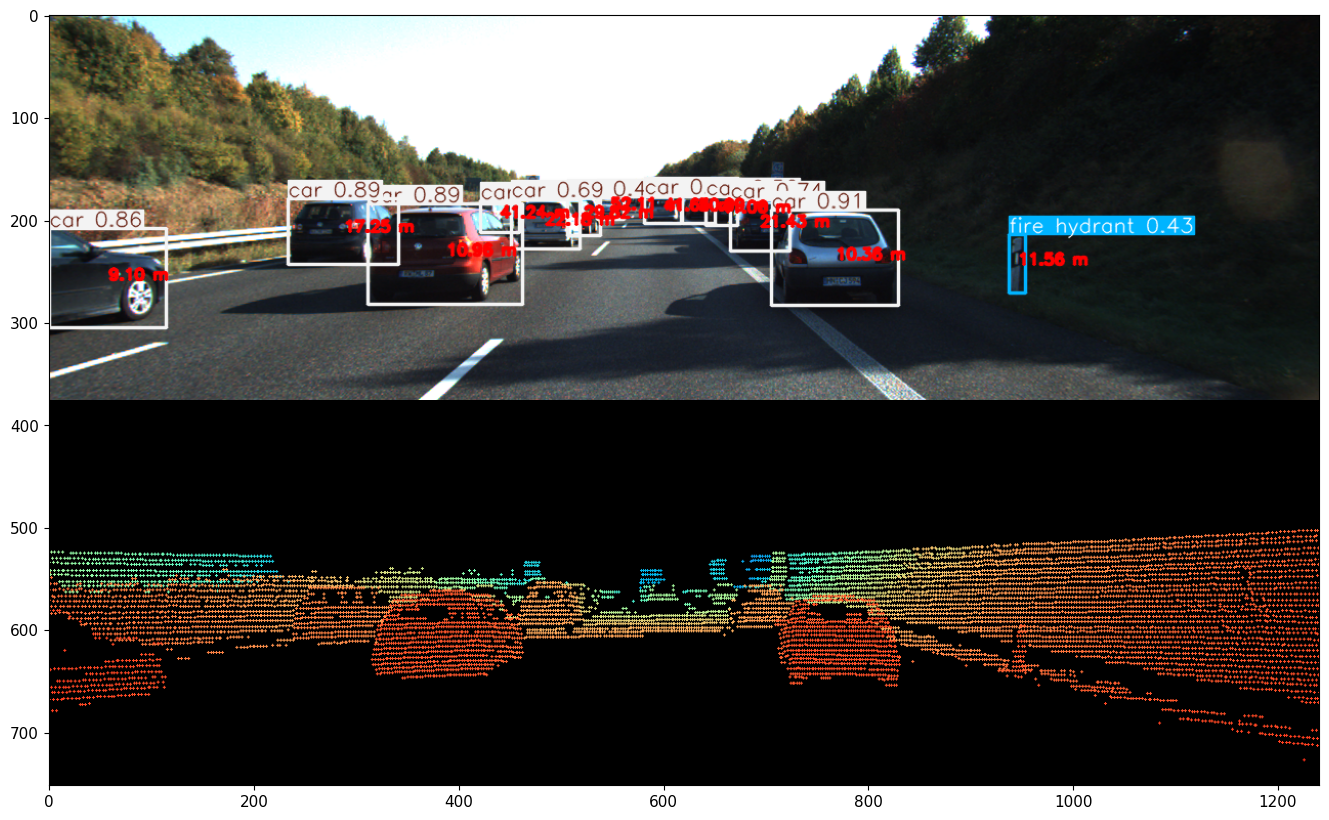

In [ ]:
# pymap3d seems to mess with matplotlib in colab
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

# stack image with LiDAR point cloud
stacked = np.vstack((left_image, velo_image))

# display stacked iamge
plt.imshow(stacked);

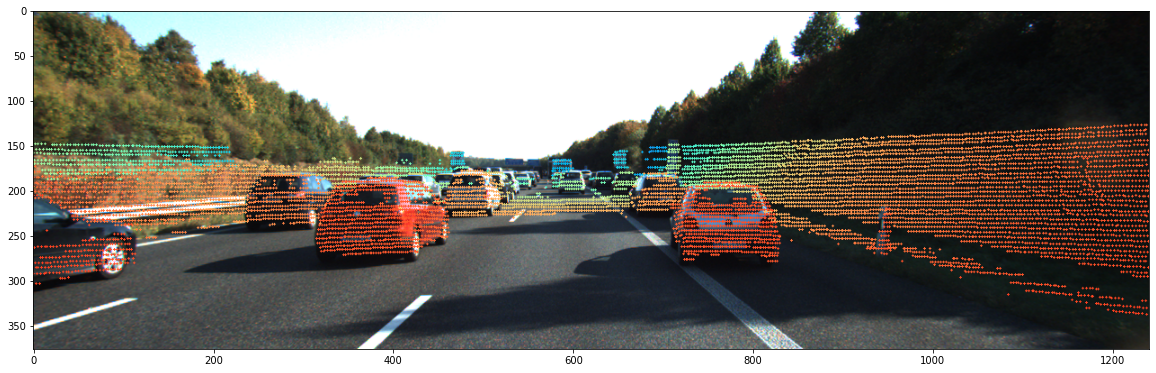

In [ ]:
left_image_2 = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
velo_image_2 = draw_velo_on_image(velo_uvz, left_image_2)

plt.imshow(velo_image_2);